In [59]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [60]:
class World:
    def __init__(self,
                lights,
                objects,
                cameras):
        self.lights = lights
        self.objects = objects
        self.cameras = cameras
        
        
class Light:
    def __init__(self, ltype, intensity, position=None, direction=None):
        self.ltype = ltype
        self.intensity = intensity
        self.position = np.array(position)
        self.direction = np.array(direction)
        
        
class Sphere:
    def __init__(self, center, radius, color, specular, reflective):
        self.center = np.array(center)
        self.radius = radius
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        self.squared_radius = None
        
    def square_radius(self):
        if self.squared_radius == None:
            self.squared_radius = self.radius * self.radius
            
        return self.squared_radius
        
class Triangle:
    def __init__(self,
              p1,
              p2,
              p3,
              color,
              specular,
              reflective):
        self.p1 = np.array(p1)
        self.p2 = np.array(p2)
        self.p3 = np.array(p3)
        
        unnormed = np.cross((self.p1 - self.p2),(self.p3 - self.p2))
        
        self.N = unnormed / np.linalg.norm(unnormed)
        
        
                            
        self.v1 = (self.p1 - self.get_vec_cpnt(self.p1,self.N)) / np.linalg.norm(self.p1 - self.get_vec_cpnt(self.p1,self.N))
        self.v2 = (self.p2 - self.get_vec_cpnt(self.p2,self.N) - self.get_vec_cpnt(self.p2,self.v1)) / \
                            np.linalg.norm(self.p2 - self.get_vec_cpnt(self.p2,self.N) - self.get_vec_cpnt(self.p2,self.v1))
                            
        self.p1_2d = np.array([np.dot(self.p1, self.v1),np.dot(self.p1, self.v2)])
        self.p2_2d = np.array([np.dot(self.p2, self.v1),np.dot(self.p2, self.v2)])
        self.p3_2d = np.array([np.dot(self.p3, self.v1),np.dot(self.p3, self.v2)])
                            
        self.color = np.array(color)
        self.specular = specular
        self.reflective = reflective
        
    def get_vec_cpnt(self, x, n_v):
        a = np.dot(n_v,x)
        comp = a*n_v
        
        return comp
        
        
class Camera:
    def __init__(self,
                 camera_position = [0, 0, 0],
                 camera_rotation = [0, 0, 0],
                 viewport_size=1,
                 projection_plane_z=1,
                 recursion_depth=3,
                 background_color=np.array([0,0,0])):
        
        x_rotate = np.array([[1, 0, 0],
                   [0, math.cos(math.pi * camera_rotation[0] / 180), -(math.sin(math.pi * camera_rotation[0] / 180))],
                   [0, math.sin(math.pi * camera_rotation[0] / 180), math.cos(math.pi * camera_rotation[0] / 180)]])
        y_rotate = np.array([[math.cos(math.pi * camera_rotation[1] / 180),0,math.sin(math.pi * camera_rotation[1] / 180)],
                   [0, 1, 0],
                   [-(math.sin(math.pi * camera_rotation[1] / 180)), 0, math.cos(math.pi * camera_rotation[1] / 180)]])
        z_rotate = np.array([[math.cos(math.pi * camera_rotation[2] / 180), -(math.sin(math.pi * camera_rotation[2] / 180)), 0],
                   [math.sin(math.pi * camera_rotation[2] / 180), math.cos(math.pi * camera_rotation[2] / 180), 0],
                   [0, 0, 1]])
        
        self.position = np.array(camera_position)
        self.rotation = np.dot(np.dot(x_rotate, y_rotate), z_rotate)
        self.viewport_size = viewport_size # view port size in world unit
        self.projection_plane_z = projection_plane_z # view port's distance from camera in world unit
        
        self.t_min = 1
        self.t_max = math.inf
        
        self.background_color = background_color
        
        self.recursion_depth = recursion_depth

    
    def trace_ray(self,
                 origin, 
                 direction,
                 objects = None, 
                 lights = None,
                 recursion_depth=3):
        origin = origin
        t_min = self.t_min
        t_max = self.t_max
        objects = objects
        closest_object, closest_t = self.intersect_closest_point(origin,
                                                        direction,
                                                        t_min,
                                                        t_max,
                                                        objects)

        if closest_object == None:
            return self.background_color

        point = np.add(origin, np.multiply(closest_t, direction))
        if isinstance(closest_object,Sphere):
            normal = np.subtract(point, closest_object.center)
        elif isinstance(closest_object,Triangle):
            normal = closest_object.N 
        normal = np.multiply(1.0 / np.linalg.norm(normal), normal)
        view = np.multiply(-1, direction)
        
        local_color = self.compute_light(point, normal, view, closest_object.specular, lights, objects) * closest_object.color
        
        # if recurrsion limit  or object is not reflective, end
        r = closest_object.reflective
        if recursion_depth <= 0 or r <= 0:
            return local_color
        
        
        # Compute reflected color
        R = self.reflectRay(view, normal)
        
        reflected_color = self.trace_ray(point, R, objects, lights, recursion_depth - 1)
        
        return local_color*(1-r) + reflected_color*r
    
    def intersect_closest_point(self, origin, direction, t_min, t_max, objects):
        closest_t = math.inf
        closest_object = None
        
        spheres = [sphere for sphere in objects if isinstance(sphere, Sphere)]
        triangles = [triangle for triangle in objects if isinstance(triangle, Triangle)]
        
        k1 = np.dot(direction,direction)
        
        for sphere in spheres:
            
            t = self.intersect_ray_sphere(origin, direction, sphere, k1)
            
            if (t_min < t[0] < t_max) & (t[0] < closest_t):
                closest_t = t[0]
                closest_object = sphere
                
            if (t_min < t[1] < t_max) & (t[1] < closest_t):
                closest_t = t[1]
                closest_object = sphere
                
        for triangle in triangles:
            
            t = self.intersect_ray_triangle(origin, direction, triangle)
            
            if (t_min < t < t_max) & (t < closest_t):
                closest_t = t
                closest_object = triangle   
                
        return closest_object, closest_t
    
    def intersect_point(self, origin, direction, t_min, t_max, objects):
        closest_t = math.inf
        closest_sphere = None
        
        spheres = [sphere for sphere in objects if isinstance(sphere, Sphere)]
        triangles = [triangle for triangle in objects if isinstance(triangle, Triangle)]
        
        k1 = np.dot(direction,direction)
        
        for sphere in spheres:
            
            t = self.intersect_ray_sphere(origin, direction, sphere, k1)
            
            if (t_min < t[0] < t_max) & (t[0] < closest_t):
                closest_t = t[0]
                closest_object = sphere
                return True
                
            if (t_min < t[1] < t_max) & (t[1] < closest_t):
                closest_t = t[1]
                closest_object = sphere
                return True
                
        for triangle in triangles:
            
            t = self.intersect_ray_triangle(origin, direction, triangle)
            
            if (t_min < t < t_max) & (t < closest_t):
                closest_t = t
                closest_object = triangle
                return True
                
        return False
    
    def intersect_ray_sphere(self, origin, direction, sphere, in_k1):
        origin = origin
        
        oc = np.subtract(origin, sphere.center)

        k1 = in_k1
        k2 = 2*np.dot(oc, direction)
        k3 = np.dot(oc,oc) - sphere.square_radius()
        # k3 = np.dot(oc, oc) - sphere.radius*sphere.radius

        discriminant = k2*k2 - 4*k1*k3
        if (discriminant < 0):
            return [math.inf, math.inf]

        t1 = (-k2 + math.sqrt(discriminant)) / (2*k1)
        t2 = (-k2 - math.sqrt(discriminant)) / (2*k1)
        return [t1, t2]
    
    def intersect_ray_triangle(self, origin, direction, triangle:Triangle):
        origin = origin
        
        t1 = np.dot(triangle.N, (triangle.p1 - origin)) / np.dot(triangle.N, direction)
        
        itc_p = origin + t1*(np.array(direction))
        
        itc_p_2d = np.array([np.dot(itc_p, triangle.v1),np.dot(itc_p, triangle.v2)])
        
        p1_p2 = (triangle.p1_2d - triangle.p2_2d)/ np.linalg.norm(triangle.p1_2d - triangle.p2_2d) # dir of line, normalized
        p1_p2_N = np.array([p1_p2[1], -p1_p2[0]]) # dir of Normal vector of line
        
        # if itc lie on the same side with p3_2d
        base_1_2 = np.dot(p1_p2_N, triangle.p1_2d) 
        
        p3_2d_based = np.dot(p1_p2_N, triangle.p3_2d) - base_1_2
        itc_based = np.dot(p1_p2_N, itc_p_2d) - base_1_2
        
        if p3_2d_based*itc_based < 0:
            return math.inf
        
        p2_p3 = (triangle.p2_2d - triangle.p3_2d)/ np.linalg.norm(triangle.p2_2d - triangle.p3_2d) # dir of line, normalized
        p2_p3_N = np.array([p2_p3[1], -p2_p3[0]]) # dir of Normal vector of line
        
        # if itc lie on the same side with p3_2d
        base_2_3 = np.dot(p2_p3_N, triangle.p2_2d) 
        
        p1_2d_based = np.dot(p2_p3_N, triangle.p1_2d) - base_2_3
        itc_based = np.dot(p2_p3_N, itc_p_2d) - base_2_3
        
        if p1_2d_based*itc_based < 0:
            return math.inf
        
        p3_p1 = (triangle.p3_2d - triangle.p1_2d)/ np.linalg.norm(triangle.p3_2d - triangle.p1_2d) # dir of line, normalized
        p3_p1_N = np.array([p3_p1[1], -p3_p1[0]]) # dir of Normal vector of line
        
        # if itc lie on the same side with p3_2d
        base_3_1 = np.dot(p3_p1_N, triangle.p3_2d) 
        
        p2_2d_based = np.dot(p3_p1_N, triangle.p2_2d) - base_3_1
        itc_based = np.dot(p3_p1_N, itc_p_2d) - base_3_1
        
        if p2_2d_based*itc_based < 0:
            return math.inf
        
        return t1
    
    def compute_light(self, point, normal, view, specular, lights, spheres):
        intensity = 0
        length_n = np.linalg.norm(normal)
        length_v = np.linalg.norm(view)
        for i, light in enumerate(lights):
            if light.ltype == 0:
                intensity += light.intensity
            else :
                vec_l = []
                if light.ltype == 1:
                    vec_l = np.subtract(light.position, point)
                    t_max = 1
                else :  #DIRECTIONAL
                    vec_l = light.direction
                    t_max = math.inf
        
            #Shadow check
                is_intersected = self.intersect_point(point, vec_l, 0.001, t_max, spheres)
                if is_intersected:
                    continue
                
          # Diffuse reflection.
                n_dot_l = np.dot(normal, vec_l)
                if( n_dot_l > 0) :
                    intensity += light.intensity * n_dot_l / (length_n * np.linalg.norm(vec_l))


          # Specular reflection.
                if (specular != -1 ):
                    vec_r = 2 * normal * np.dot(normal, vec_l) - vec_l
                    # vec_r = np.subtract(np.multiply(2.0*np.dot(normal, vec_l), normal), vec_l)
                    r_dot_v = np.dot(vec_r, view)
                    if (r_dot_v > 0):
                        intensity += light.intensity * math.pow(r_dot_v / (np.linalg.norm(vec_r) * length_v), specular)
        return np.array(intensity)
    
    def reflect_ray(self,R,N):
        return 2 * N * np.dot(N, R) - R

In [61]:
class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8)
        
    def put_pixel(self, x, y, color):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B))
        
        
class Renderer:
    '''
    Canvas
    World
    '''
    def __init__(self,
                canvas,
                world):
        self.canvas = canvas 
        self.world = world
    
    def render(self, camera_idx=0):
        canvas_width = self.canvas.width
        canvas_height = self.canvas.height
        
        
        
        x_s = -canvas_width/2
        y_s = -canvas_height/2
        
        for i in range(canvas_width):
            for j in range(canvas_height):
                curr_x = x_s + i
                curr_y = y_s + j
                direction = self.canvas2viewport([curr_x, curr_y], camera_idx)
                direction = np.dot(self.world.cameras[camera_idx].rotation, direction)
                color = self.trace_ray(camera_idx, direction)
                #color = trace_ray(camera_position, direction, 1, math.inf)
                self.canvas.put_pixel(curr_x, curr_y,color)
        
        plt.imshow(self.canvas.img)
        return 
    
    def canvas2viewport(self, point2d, camera_idx):
        camera = self.world.cameras[camera_idx]
        
        viewport_size = camera.viewport_size
        canvas_width = self.canvas.width
        canvas_height = self.canvas.height
        projection_plane_z = camera.projection_plane_z
        
        return [point2d[0] * viewport_size / canvas_width, point2d[1] * viewport_size / canvas_height, projection_plane_z]
    
    def trace_ray(self, camera_idx, direction):
        camera = self.world.cameras[camera_idx]
        
        color = camera.trace_ray(camera.position,
                                direction,  
                                objects=self.world.objects, 
                                lights = self.world.lights,
                                recursion_depth=camera.recursion_depth)
        
        # color = trace_ray(camera_position, direction, 1, math.inf)
        return color

In [62]:
AMBIENT = 0
POINT = 1
DIRECTIONAL = 2

light1 = Light(AMBIENT, 0.2, None)
light2 = Light(POINT, 0.6, position=[2,1,0])
light3 = Light(DIRECTIONAL, 0.2, direction=[1,4,4])
lights = [light1, light2, light3]


sphere1 = Sphere([0, -1, 3], 1, [255, 0, 0], 500, 0.2)
sphere2 = Sphere([2, 0, 4], 1, [0, 255, 0], 500, 0.3)
sphere3 = Sphere([-2, 0, 4], 1, [0, 0, 255], 10, 0.4)
sphere4 = Sphere([0, -5001, 0], 5000, [255, 255, 0], 1000, 0.5)

triangle1 = Triangle([0,1,3], [0, -1, 3], [2, 0, 4],
                 [255, 0, 0], 500, 0.2)
triangle2 = Triangle([0,1,6], [0, -1, 6], [-2, 0, 4],
                 [255, 0, 255], 500, 0.2)
triangle3 = Triangle([0, 4, 3], [2, 1, 4], [-2, 0, 4],
                 [255, 255, 255], 500, 0.2)

objects = [sphere1, sphere2, sphere3, sphere4, triangle1,triangle2,triangle3]

camera1 = Camera(camera_position=[3,0,1], camera_rotation=[0,-45,0], recursion_depth=0) # no reflection
camera2 = Camera(camera_position=[0,3,0], camera_rotation=[45,0,0], recursion_depth=3)# reflection
camera3 = Camera(camera_position=[0,10,3], camera_rotation=[90,0,0], recursion_depth=0, background_color=[255,255,255])
cameras = [camera1, camera2, camera3]

world = World(lights=lights,
             objects=objects,
             cameras=cameras)

canvas = Canvas()

renderer = Renderer(canvas, world)

Wall time: 1min 28s


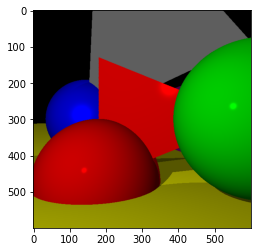

In [63]:
%%time
renderer.render()